In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d

# Just for plotting
plt.style.use('ggplot')
# Default params
params = {
    'image.origin':'lower',
    'image.interpolation':'nearest',
    'image.cmap':'magma',
    'axes.titlesize':22,
    'font.size':14,
    'xtick.labelsize':20,
    'ytick.labelsize':20,
    'lines.linewidth':4,
    'font.family':'sans serif',
    'axes.labelsize':30,
}
mpl.rcParams.update(params)

# Simulating Multilayer Thin Films

Thin films optical filters let us control reflection, transmission, bandwidth, and polarization. Unfortunately, they are also the primary cause of polarization aberrations. Due to their relevance in polarization ray tracing, we've implemented the ability to compute the effective fresnel reflection coefficients given a thin film multilayer stack. These can also be used in polarization ray tracing calculations to understand how their presence impacts the Jones pupil. Currently Poke supports the characteristic matrix method outlined in the BYU Optics Book [1] by Peatross and Ware $^{*}$ (It's free and great, please check it out). In this demo we go into how to use Poke to simulate the complex amplitude coefficients of a multilayer stack, and then use Python to optimize the stack to become a long-pass filter. 


$^{*}$ Past versions of Poke have used the Macleod [2] characteristic matrix algorithm, but they produce identical results (with opposite phases), so the choice between the two is more about your phase sign convention than anything else.

**References**
- [1] J. Peatross and M. Ware, Physics of Light and Optics, 2015 edition, available at optics.byu.edu
- [2] A. H. Macleod, Thin-film Optical Filters, 1969 edition, Taylor and Francis

We begin by loading some material data. Poke includes a limited selection of material data from refractiveindex.info (another great, free resources). One day we will have a more formal material catalogue, but for now - please bear with me as I parse some csv's.

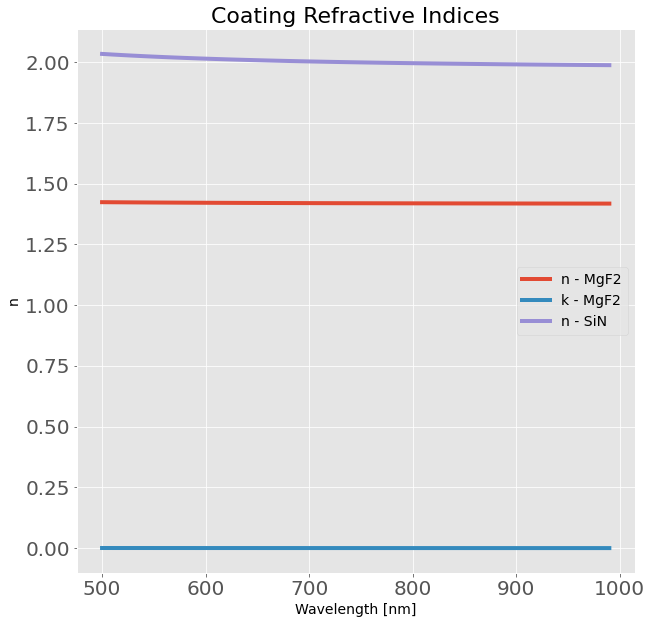

In [31]:
# Load in some coatings
pth = '/Users/jashcraft/Desktop/poke/material_data/'
pth_to_SiN = pth+'Philipp_SiN.csv'
dat_SiN = np.genfromtxt(pth_to_SiN,delimiter=',',skip_header=1)[:500].T
n_SiN = interp1d(dat_SiN[0],dat_SiN[1])

pth_MgF2 = pth+'Rodriguez-de Marcos_MgF2.csv'
dat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[:962].T
kdat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[964:].T
nd_MgF2 = interp1d(dat_MgF2[0],dat_MgF2[1])
k_MgF2 = interp1d(kdat_MgF2[0],kdat_MgF2[1])
n_MgF2 = lambda wave: nd_MgF2(wave) + 1j*k_MgF2(wave)

# generate some wavelengths
wvl = np.arange(500,1000,10)*1e-3

plt.figure(figsize=[10,10])
plt.plot(wvl*1e3,nd_MgF2(wvl),label='n - MgF2')
plt.plot(wvl*1e3,k_MgF2(wvl),label='k - MgF2')
plt.plot(wvl*1e3,n_SiN(wvl),label='n - SiN')
plt.legend()
plt.title('Coating Refractive Indices')
plt.xlabel('Wavelength [nm]')
plt.ylabel('n')
plt.show()

These coatings were chosen to have a "high" and a "low" refractive index. The interaction of a given coating interface is directly related to the difference in refractive index, so this makes our coatings a little "stronger". 

The next step is to load these data into a format that makes Poke happy. For stacks, we use a list of tuples of the format [(index_1,thickness_1),(index_2,thickness_2),...,(index_N,thickness_N),(substrate_index)]. Note that the final element of the list must be the substrate index. We will arbitrarily choose to use a 50nm thickness for each of the layers, and send the inputs to the `poke.thinfilms.compute_thin_films_broadcasted` method.

In [32]:
from poke.thinfilms import compute_thin_films_broadcasted
aoi = 45
stack = [
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (n_SiN(wvl),np.full_like(wvl,50e-3)),
    (n_MgF2(wvl),np.full_like(wvl,50e-3)),
    (1.5)
]

aoi = np.full_like(wvl,aoi)

rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5)
rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5,polarization='p')


We used 20 coating layers alternating between a high and low refractive index. This was done without much consideration for what the actual reflectance is, so we plot it below. It isn't terribly exciting, but might make a neat mix of colors. Let's see if we can optimize it to make a long-pass filter.

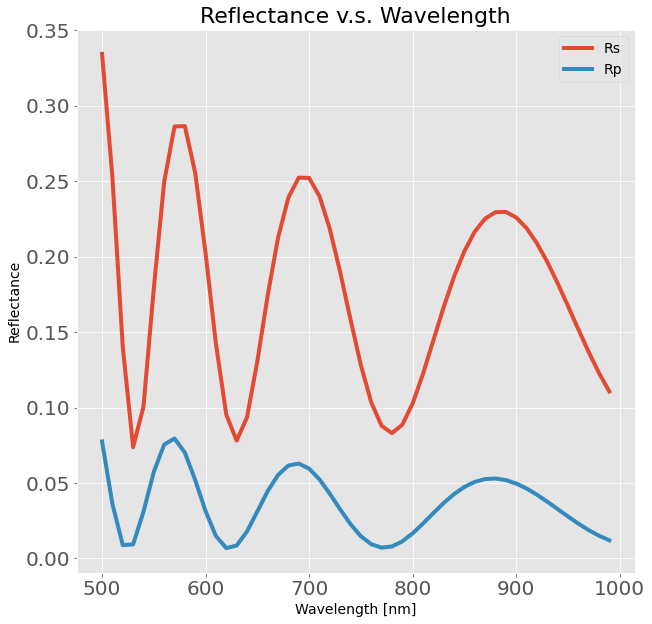

In [33]:
plt.figure(figsize=[10,10])
plt.title('Reflectance v.s. Wavelength')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength [nm]')
plt.plot(wvl*1e3,np.abs(rs)**2,label='Rs')
plt.plot(wvl*1e3,np.abs(rp)**2,label='Rp')
plt.legend()
plt.show()

To do so we need only construct a cost function for the `scipy.optimize.minimize` library, and a starting point (we'll use the one above for fun). We construct the cost function to maximize reflectance after 600nm and minmize reflectance short of 600nm.

In [34]:
from scipy.optimize import minimize

def costfunc(a):

    aoi = 45
    wvl = np.arange(500,1000,5)*1e-3
    stack = [
        (n_SiN(wvl),np.full_like(wvl,a[0])),
        (n_MgF2(wvl),np.full_like(wvl,a[1])),
        (n_SiN(wvl),np.full_like(wvl,a[2])),
        (n_MgF2(wvl),np.full_like(wvl,a[3])),
        (n_SiN(wvl),np.full_like(wvl,a[4])),
        (n_MgF2(wvl),np.full_like(wvl,a[5])),
        (n_SiN(wvl),np.full_like(wvl,a[6])),
        (n_MgF2(wvl),np.full_like(wvl,a[7])),
        (n_SiN(wvl),np.full_like(wvl,a[8])),
        (n_MgF2(wvl),np.full_like(wvl,a[9])),
        (n_SiN(wvl),np.full_like(wvl,a[10])),
        (n_MgF2(wvl),np.full_like(wvl,a[11])),
        (n_MgF2(wvl),np.full_like(wvl,a[12])),
        (n_SiN(wvl),np.full_like(wvl,a[13])),
        (n_MgF2(wvl),np.full_like(wvl,a[14])),
        (n_MgF2(wvl),np.full_like(wvl,a[15])),
        (n_SiN(wvl),np.full_like(wvl,a[16])),
        (n_MgF2(wvl),np.full_like(wvl,a[17])),
        (n_MgF2(wvl),np.full_like(wvl,a[18])),
        (n_SiN(wvl),np.full_like(wvl,a[19])),
        (n_MgF2(wvl),np.full_like(wvl,a[20])),
        (1.5)
    ]

    aoi = np.full_like(wvl,aoi)

    rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5)
    rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5,polarization='p')
    R = (np.abs(rs)**2 + np.abs(rp)**2)/2

    # The cost function
    short = R[wvl<0.6]
    long = 1 - R[wvl>=0.6]
    cost_short = np.sum(short**2)
    cost_long = np.sum(long**2)
    cost = (cost_short + cost_long)/R.size

    return cost

a = np.zeros(21)
a[:] = 50e-3
results = minimize(costfunc,a,method='BFGS',options={'maxiter':100})

Now we just re-evaluate this to return the results!

In [35]:
aoi = 45
a = results.x
wvl = np.arange(500,1000,5)*1e-3
stack = [
    (n_SiN(wvl),np.full_like(wvl,a[0])),
    (n_MgF2(wvl),np.full_like(wvl,a[1])),
    (n_SiN(wvl),np.full_like(wvl,a[2])),
    (n_MgF2(wvl),np.full_like(wvl,a[3])),
    (n_SiN(wvl),np.full_like(wvl,a[4])),
    (n_MgF2(wvl),np.full_like(wvl,a[5])),
    (n_SiN(wvl),np.full_like(wvl,a[6])),
    (n_MgF2(wvl),np.full_like(wvl,a[7])),
    (n_SiN(wvl),np.full_like(wvl,a[8])),
    (n_MgF2(wvl),np.full_like(wvl,a[9])),
    (n_SiN(wvl),np.full_like(wvl,a[10])),
    (n_MgF2(wvl),np.full_like(wvl,a[11])),
    (n_MgF2(wvl),np.full_like(wvl,a[12])),
    (n_SiN(wvl),np.full_like(wvl,a[13])),
    (n_MgF2(wvl),np.full_like(wvl,a[14])),
    (n_MgF2(wvl),np.full_like(wvl,a[15])),
    (n_SiN(wvl),np.full_like(wvl,a[16])),
    (n_MgF2(wvl),np.full_like(wvl,a[17])),
    (n_MgF2(wvl),np.full_like(wvl,a[18])),
    (n_SiN(wvl),np.full_like(wvl,a[19])),
    (n_MgF2(wvl),np.full_like(wvl,a[20])),
    (1.5)
]

aoi = np.full_like(wvl,aoi)

rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5)
rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wvl,substrate_index=1.5,polarization='p')
R = (np.abs(rs)**2 + np.abs(rp)**2)/2

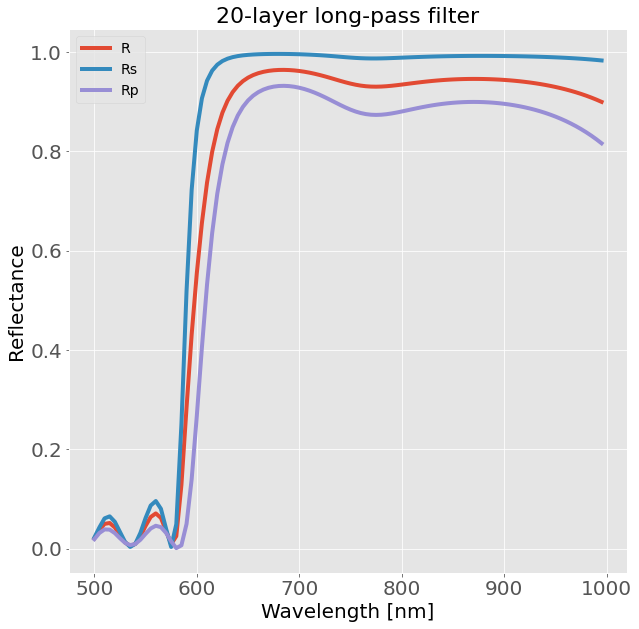

In [36]:
plt.figure(figsize=[10,10])
plt.title('20-layer long-pass filter')
plt.plot(wvl*1e3,R,label='R')
plt.plot(wvl*1e3,np.abs(rs)**2,label='Rs')
plt.plot(wvl*1e3,np.abs(rp)**2,label='Rp')
plt.legend()
plt.ylabel('Reflectance',fontsize=20)
plt.xlabel('Wavelength [nm]',fontsize=20)
plt.show()

And it does exactly what we wanted! This is a relatively simple and brute-force method of designing optical filters, but it is nice the Poke has the flexibility to set up the design platform in Python. In future demos we will illustrate:
- how to use one of these filters in polarization ray tracing
- setting up the problem to be differentiable using Jax
- faster optimization on GPUs